# Adrian Zaręba | 320672
## NN6 - Zjawisko przeuczenia oraz regularyzacja

##### Obecny model bardzo rzadko (wręcz prawie wcale) spotyka się ze stałym wzrostem MSE (w przypadku regresji oraz stałym spadkiem F-measure dla klasyfikacji) dla późniejszych epoch. Występuje jednak zjawisko mocnych skoków wartości MSE, przez co algorytm 'łapiący' potencjalny wzrost MSE będzie musiał być nieco bardziej skomplikowany. P.S. Normalizacja wprowadzona była już wcześniej, dlatego w tym temacie zmian nie oczekujemy. Szybki komentarz odnośnie normalizacji: dzięki temu rozwiązaniu model ma dużo większy potencjał na wytrenowanie przez chociażby inicjalizację wag (Xavier, he, norm).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## | Dane
### Pobieranie danych oraz ich przetwarzanie w celach wizualizacji

### Klasyfikacja

In [2]:
rings3_balance_test = pd.read_csv('rings3-balance-test.csv')[['x', 'y', 'c']]
rings3_balance_test_x, rings3_balance_test_y, rings3_balance_test_c = rings3_balance_test['x'].values.reshape(-1, 1), rings3_balance_test['y'].values.reshape(-1, 1), rings3_balance_test['c'].values.reshape(-1, 1)
rings3_balance_train = pd.read_csv('rings3-balance-training.csv')[['x', 'y', 'c']]
rings3_balance_train_x, rings3_balance_train_y, rings3_balance_train_c = rings3_balance_train['x'].values.reshape(-1, 1), rings3_balance_train['y'].values.reshape(-1, 1), rings3_balance_train['c'].values.reshape(-1, 1)

rings5_sparse_test = pd.read_csv('rings5-sparse-test.csv')[['x', 'y', 'c']]
rings5_sparse_test_x, rings5_sparse_test_y, rings5_sparse_test_c = rings5_sparse_test['x'].values.reshape(-1, 1), rings5_sparse_test['y'].values.reshape(-1, 1), rings5_sparse_test['c'].values.reshape(-1, 1)
rings5_sparse_train = pd.read_csv('rings5-sparse-training.csv')[['x', 'y', 'c']]
rings5_sparse_train_x, rings5_sparse_train_y, rings5_sparse_train_c = rings5_sparse_train['x'].values.reshape(-1, 1), rings5_sparse_train['y'].values.reshape(-1, 1), rings5_sparse_train['c'].values.reshape(-1, 1)

xor3_balance_test = pd.read_csv('xor3-balance-test.csv')[['x', 'y', 'c']]
xor3_balance_test_x, xor3_balance_test_y, xor3_balance_test_c = xor3_balance_test['x'].values.reshape(-1, 1), xor3_balance_test['y'].values.reshape(-1, 1), xor3_balance_test['c'].values.reshape(-1, 1)
xor3_balance_train = pd.read_csv('xor3-balance-training.csv')[['x', 'y', 'c']]
xor3_balance_train_x, xor3_balance_train_y, xor3_balance_train_c = xor3_balance_train['x'].values.reshape(-1, 1), xor3_balance_train['y'].values.reshape(-1, 1), xor3_balance_train['c'].values.reshape(-1, 1)

print(f'Size of the Rings3 Balance: {len(rings3_balance_train)}')
print(f'Size of the Rings5 Sparse: {len(rings5_sparse_train)}')
print(f'Size of the Xor3 Balance: {len(xor3_balance_train)}')

Size of the Rings3 Balance: 2060
Size of the Rings5 Sparse: 200
Size of the Xor3 Balance: 1050


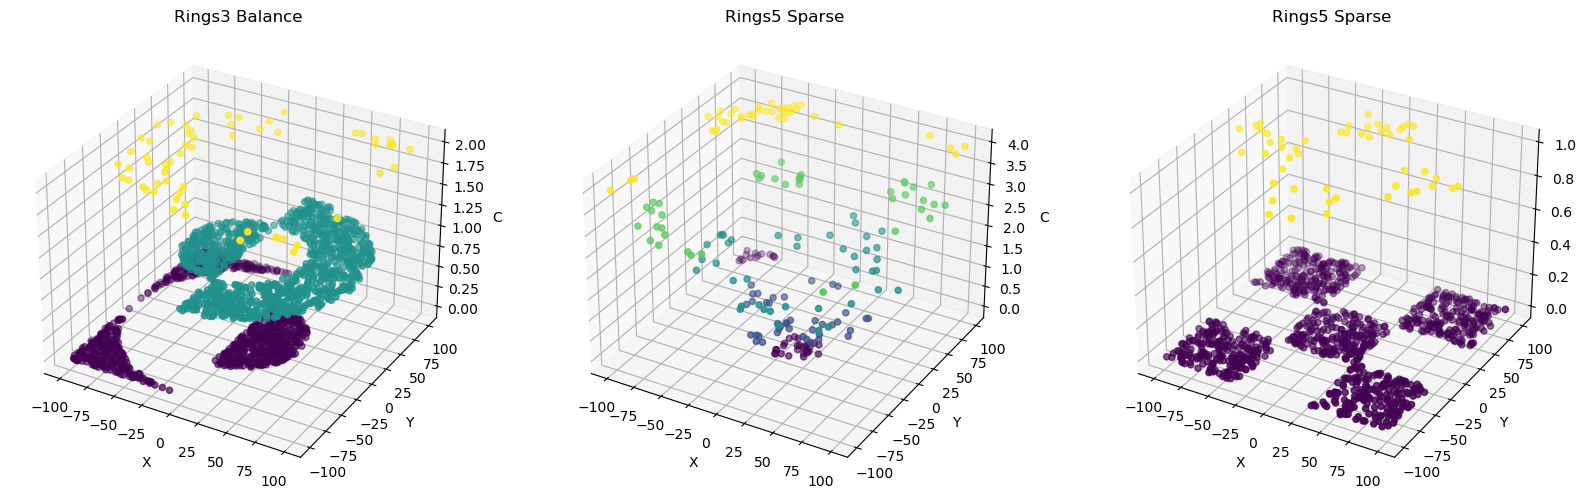

In [3]:
def plot_3d_subplot(ax, x, y, c, title='3D Plot'):
    scatter = ax.scatter(x, y, c, c=c, cmap='viridis', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('C')
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': '3d'})

plot_3d_subplot(axes[0], rings3_balance_train_x, rings3_balance_train_y, rings3_balance_train_c, title='Rings3 Balance')
plot_3d_subplot(axes[1], rings5_sparse_train_x, rings5_sparse_train_y, rings5_sparse_train_c, title='Rings5 Sparse')
plot_3d_subplot(axes[2], xor3_balance_train_x, xor3_balance_train_y, xor3_balance_train_c, title='Rings5 Sparse')

plt.show()

### Następnie w celach klasyfikacji danych zmienimy podejście w ich przetwarzaniu, stosując One-Hot Encoding 

In [4]:
def one_hot_encode(y):
    return pd.get_dummies(y, dtype=int).to_numpy()

XY_rings3_balance_train = rings3_balance_train[['x', 'y']].to_numpy()
c_rings3_balance_train = one_hot_encode(rings3_balance_train['c'])
XY_rings3_balance_test = rings3_balance_test[['x', 'y']].to_numpy()
c_rings3_balance_test = one_hot_encode(rings3_balance_test['c'])

XY_rings5_sparse_train = rings5_sparse_train[['x', 'y']].to_numpy()
c_rings5_sparse_train = one_hot_encode(rings5_sparse_train['c'])
XY_rings5_sparse_test = rings5_sparse_test[['x', 'y']].to_numpy()
c_rings5_sparse_test = one_hot_encode(rings5_sparse_test['c'])

XY_xor3_balance_train = xor3_balance_train[['x', 'y']].to_numpy()
c_xor3_balance_train = one_hot_encode(xor3_balance_train['c'])
XY_xor3_balance_test = xor3_balance_test[['x', 'y']].to_numpy()
c_xor3_balance_test = one_hot_encode(xor3_balance_test['c'])

### Regresja

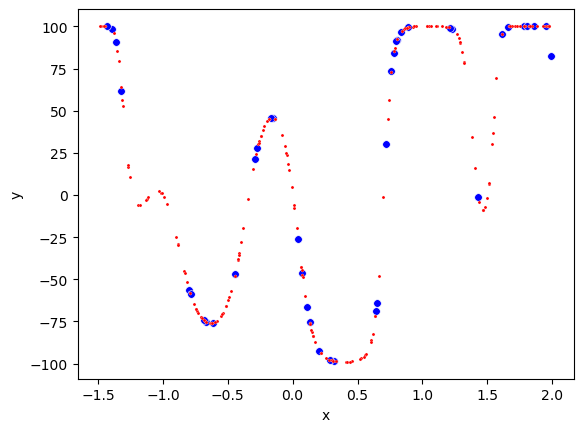

In [5]:
multimodal_sparse_test = pd.read_csv('multimodal-sparse-test.csv')[['x', 'y']]
multimodal_sparse_train = pd.read_csv('multimodal-sparse-training.csv')[['x', 'y']]
Multimodal_Sparse_Test_X, Multimodal_Sparse_Test_y = multimodal_sparse_test['x'].values.reshape(-1, 1), multimodal_sparse_test['y'].values.reshape(-1, 1)
Multimodal_Sparse_Train_X, Multimodal_Sparse_Train_y = multimodal_sparse_train['x'].values.reshape(-1, 1), multimodal_sparse_train['y'].values.reshape(-1, 1)

sns.scatterplot(data=multimodal_sparse_train, x='x', y='y', color='blue', s=30)
sns.scatterplot(data=multimodal_sparse_test, x='x', y='y', color='red', s=5)
axes[0].set_title('Multimodal Sparse')

plt.show()

# | Neural Network

In [ ]:
# Funkcje aktywacji i ich pochodne
activation_functions = {
    'sigmoid': lambda z: 1 / (1 + np.exp(-z)),
    'linear': lambda z: z,
    'relu' : lambda z: np.maximum(0, z),
    'softmax' : lambda z: np.exp(z - np.max(z)) / np.exp(z - np.max(z)).sum(axis=1, keepdims=True),
    'tanh': lambda z: np.tanh(z)

}

derivative_activation_functions = {
    "sigmoid": lambda x: x * (1 - x),
    "linear": lambda x: 1,
    "relu": lambda x: (x > 0).astype(float),
    "tanh": lambda x: 1 - np.tanh(x)**2 
}

# Funkcje inicjalizacji wag
initialization_functions = {
    'xavier': lambda n_in, n_out=None: np.random.normal(0, np.sqrt(1. / n_out if n_out is not None else 1. / n_in), (n_in, n_out) if n_out is not None else n_in),
    'he': lambda n_in, n_out=None: np.random.normal(0, np.sqrt(2. / n_in), (n_in, n_out) if n_out is not None else n_in),
    'uniform': lambda n_in, n_out=None: np.random.uniform(0, 1, (n_in, n_out) if n_out is not None else n_in),
}

# Klasa reprezentująca sztuczną sieć neuronową
class NN:
    def __init__(self, architecture, activations='sigmoid', initalization='uniform', model_type='regression', activation_output='linear'):
        """
        Inicjalizacja sztucznej sieci neuronowej.
        Parameters:
        architecture (list): Lista liczby neuronów w każdej warstwie.
        activations (str): Rodzaj funkcji aktywacji używanej we wszystkich warstwach poza ostatnią.
        initialization (str): Metoda inicjalizacji wag.
        """
        self.architecture = architecture
        self.num_layers = len(architecture)
        self.training_process = [[], []]  # Przechowywanie procesu uczenia
        self.weights_history = []  # Historia wag
        self.model_type = model_type # Typ modelu
        if self.architecture[-1] == 1 and model_type != 'regression':
            raise Exception('Determining regression is possible only with one-dimensional output. Change the architecture.')

        # Wybór funkcji inicjalizacji wag
        self.init_function = initialization_functions[initalization]
        # Inicjalizacja wag i biasów
        self.weights = [self.init_function(architecture[i-1], architecture[i]) for i in range(1, self.num_layers)]
        self.biases = [self.init_function(architecture[i]) for i in range(1, self.num_layers)]

        # Kojarzy mi się z velocity dla momentum. Inicjalizacja też tutaj dla RMSProp
        self.s_weights = [np.zeros_like(w) for w in self.weights]
        self.s_biases = [np.zeros_like(b) for b in self.biases]

        # Dobór funkcji na outpucie w zależności od modelu
        #if model_type == 'regression':
        #    activation_output = 'linear'
        #elif model_type == 'classification':
        #    activation_output = 'softmax'

        # Wybór funkcji aktywacji
        self.activations = [activations for i in range(1, self.num_layers - 1)] + [activation_output]
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), [activations for i in range(1, self.num_layers - 1)] + [activation_output]))


    def record_weights(self):
        """Zapisuje bieżące wagi sieci."""
        self.weights_history.append([w.copy() for w in self.weights])


    def forward(self, a, return_activations=False):
        """
        Przekazuje dane przez sieć w kierunku od wejścia do wyjścia.
        Parameters:
        a (numpy.ndarray): Wejście sieci.
        return_activations (bool): Określa, czy zwracać aktywacje na każdej warstwie.
        Returns:
        numpy.ndarray: Wyjście sieci.
        """        
        activations = [a] if return_activations else None
        
        for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
            a = func(np.dot(a, w)+b)
            if return_activations:
                activations.append(a)
        return activations if return_activations else a
    
    
    def MSE(self, X, y, denormalize=None):
        """
        Oblicza błąd średniokwadratowy dla danych wejściowych i oczekiwanych wyjść.
        Parameters:
        X (numpy.ndarray): Dane wejściowe.
        y (numpy.ndarray): Oczekiwane wyjścia.
        denormalize (tuple): Tuple zawierający parametry do denormalizacji danych.
        Returns:
        float: Błąd średniokwadratowy.
        """
        predictions = self.forward(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    
    def fmeasure(self, X, y):
        """
        Oblicza miarę F dla modelu na podstawie danych wejściowych i oczekiwanych wyjść.
        Parameters:
        X (numpy.ndarray): Dane wejściowe.
        y (numpy.ndarray): Oczekiwane wyjścia.
        Returns:
        float: Miera F dla modelu na podstawie danych wejściowych i oczekiwanych wyjść.
        """
        predictions = self.forward(X)
        predictions = predictions.flatten()
        y = y.flatten()
        
        unique_classes = np.unique(y)
        predictions_new = np.array([unique_classes[np.argmin(np.abs(unique_classes - prediction))] for prediction in predictions])
        predictions_new = predictions_new.astype(y.dtype)

        true_positives = np.sum(np.equal(predictions_new, y))
        precision = true_positives / len(predictions_new)
        recall = true_positives / np.sum(np.isin(y, predictions_new))
        if precision + recall == 0:
            return 0
        fmeasure = 2 * (precision * recall) / (precision + recall)
        return fmeasure


    def backward(self, X, y, learning_rate, sigma, beta, epsilon):
        """Propagacja wsteczna"""
        # sigma: szybkość dla momentum
        # beta: współczynnik zapominania dla RMSProp
        # epsilon: anty-zero
        activations = self.forward(X, return_activations=True)
        deltas = [None] * len(self.weights)
        deltas[-1] = activations[-1] - y
        
        for i in reversed(range(len(deltas) - 1)):
            delta_func = derivative_activation_functions[self.activations[i]]
            deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * delta_func(activations[i+1])
        
        length = len(self.weights)
        weights_gradient = [None] * length
        biases_gradient = [None] * length
        
        for i in range(length):
            weights_gradient[i] = np.dot(activations[i].T, deltas[i])
            biases_gradient[i] = np.sum(deltas[i], axis=0)

        if sigma is None:
            sigma = 0
                
        m = len(X)
        for i in range(len(self.weights)):
            weights_gradient = np.dot(activations[i].T, deltas[i])
            biases_gradient = np.sum(deltas[i], axis=0)
            # Aktualizacja wag
            if beta is not None:
                # RMSProp
                # Tutaj learning rate nie jest dzielony przez len(X). Wygodniej i sprawniej bez tego
                self.s_weights[i] = beta * self.s_weights[i] + (1 - beta) * np.square(weights_gradient)
                self.s_biases[i] = beta * self.s_biases[i] + (1 - beta) * np.square(biases_gradient)
                self.weights[i] -= (learning_rate / ((np.sqrt(self.s_weights[i] + epsilon)))) * weights_gradient
                self.biases[i] -= (learning_rate / ((np.sqrt(self.s_biases[i] + epsilon)))) * biases_gradient
            else:
                # Momentum
                self.s_weights[i] = sigma * self.s_weights[i] + (1 - sigma) * weights_gradient
                self.s_biases[i] = sigma * self.s_biases[i] + (1 - sigma) * biases_gradient
                self.weights[i] -= (learning_rate / m) * self.s_weights[i]
                self.biases[i] -= (learning_rate / m) * self.s_biases[i]


    def create_batches(self, X, y, batch_size):
        """
        Tworzy batche danych wejściowych i oczekiwanych wyjść.
        Parameters:
        X (numpy.ndarray): Dane wejściowe.
        y (numpy.ndarray): Oczekiwane wyjścia.
        batch_size (int): Rozmiar batcha.
        Returns:
        tuple: Tuple zawierający batche danych wejściowych i oczekiwanych wyjść.
        """
        size = len(X)
        indices = np.arange(size)
        np.random.shuffle(indices)
        # Tutaj wsadzamy procent, jeżeli nie znamy wielkości zbioru
        if batch_size <= 1:
            batch_size = round(size*batch_size)
        
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        X_mini_batches = [X_shuffled[i:i+batch_size] for i in range(0, size, batch_size)]
        y_mini_batches = [y_shuffled[i:i+batch_size] for i in range(0, size, batch_size)]
        return X_mini_batches, y_mini_batches
    

    def train(self, X, y, X_test, y_test, denormalize=None,       # Dane
              learning_rate=0.01, epochs=10000, batch_size=None,  # Podstawowe zmienne
              velocity=None, beta=None, epsilon=1e-8,             # Zmienne dla gradientów
              target=None, update_rate=1, auto_stop=False):       # Dodatkowe
        """
        Trenuje sieć neuronową.
        Parameters:
        X (numpy.ndarray): Dane treningowe.
        y (numpy.ndarray): Oczekiwane wyjścia dla danych treningowych.
        X_test (numpy.ndarray): Dane testowe.
        y_test (numpy.ndarray): Oczekiwane wyjścia dla danych testowych.
        learning_rate (float): Współczynnik uczenia.
        epochs (int): Liczba epok.
        batch_size (int): Rozmiar batcha.
        denormalize (tuple): Tuple zawierający parametry do denormalizacji danych.
        target (float): Wartość MSE na której chcemy zakończyć uczenie.
        update_rate (int): Częstotliwość aktualizacji wyników. (Przyczynia się do czasu działania)
        velocity (float): Parametr kontrolujący tempo i kierunek aktualizacji wag
        beta (float): Parametr dla RMSProp
        epsilon (float): anty-zero
        auto_stop (int): przeciw przetrenowaniu
        """
        warnings.filterwarnings("ignore", category=RuntimeWarning)      

        if self.model_type != "regression" and target is not None:
            if target > 1:
                print('For classification F-measure must be less than 1')
                return

        if velocity is not None and beta is not None:
            print('You need to choose between simple momentum and RMSProp')
            return
        
        if batch_size is None:
            batch_size = len(X)
        
        y_mse_fmeasure = y
        if denormalize is not None:
            y_mse_fmeasure = destandardize_data(y, denormalize)

        # Do wizualizacji procesu. W print ważne przy określaniu dokładności wyświetlanych wyników
        field_width = 8
        # Do mechanizmu autostop
        means = []
        percent_of_epochs = int(epochs*auto_stop)

        try:
            loss_test = 0
            for epoch in range(1, epochs+1):
                if batch_size < len(X):
                    batches_x, batches_y = self.create_batches(X, y, batch_size)
                    for i in range(len(batches_x)):
                        self.backward(batches_x[i], batches_y[i], learning_rate, velocity, beta, epsilon)
                else:
                    self.backward(X, y, learning_rate, velocity, beta, epsilon)
                
                if (epoch % update_rate) == 0 or epoch == epochs:
                    self.record_weights()
                    if not self.model_type != "regression":
                        loss = self.MSE(X, y_mse_fmeasure, denormalize=denormalize)
                        loss_test = self.MSE(X_test, y_test, denormalize=denormalize)
                        self.training_process[0].append(epoch)
                        self.training_process[1].append(loss)
                        print(f"MSE Test: {loss_test:>{field_width}.2f} | MSE Train: {loss:>{field_width}.2f} | Percentage: {((epoch/epochs)*100):>{field_width}.2f}%", end='\r')
                    elif self.model_type != "regression":
                        loss = self.fmeasure(X, y_mse_fmeasure)
                        loss_test = self.fmeasure(X_test, y_test)
                        self.training_process[0].append(epoch)
                        self.training_process[1].append(loss)
                        print(f"F-measure Test: {loss_test:>{field_width}.4f} | F-measure Train: {loss:>{field_width}.4f} | Percentage: {((epoch/epochs)*100):>{field_width}.2f}%", end='\r')
                        
                    #Dodanie auto_stop
                    if auto_stop:
                        if epoch >= percent_of_epochs:
                            if (epoch - percent_of_epochs)%(percent_of_epochs) == 0:
                                means.append(np.mean(self.training_process[1][-percent_of_epochs:]))
                        if len(means) >= 2:
                            if self.model_type == 'regression':
                                if means[-1] > means[-2]:
                                    print("Expected Overfitting. Needed to stop process.")
                                    return
                            else:
                                if means[-1] < means[-2]:
                                    print("Expected Overfitting. Needed to stop process.")
                                    return

                if target is not None and self.model_type != "regression":
                    if loss_test >= target:
                        return
                if target is not None and not self.model_type != "regression":
                    if loss_test <= target:
                        return
        except KeyboardInterrupt:
            print("\nTraining interrupted. Finalizing...")
        except OverflowError:
            result = None 
        except ValueError as e:
            if "operands could not be broadcast together with shapes" in str(e):
                print("Output dimension probably doesn't match the class count. Change the architecture.")
            else:
                raise e
        finally:
            print("Training complete.")
            if not self.model_type != "regression":
                print(f"Final MSE: {loss_test:>{field_width-3}.2f}", end='\r') 
            elif self.model_type != "regression":
                print(f"Final F-measure: {loss_test:>{field_width-3}.2f}", end='\r') 

                

    # Funkcje wizualizacyjne
    def plot_combined(self, X, parameters=None, data=None):
        """
        Wyświetla wykresy predykcji oraz procesu trenowania.
        Parameters:
        X (numpy.ndarray): Dane wejściowe.
        """
        if not self.model_type != "regression":
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            predictions = []
            for x in X:
                predictions.append(self.forward(x)[-1])
            predictions = self.forward(X)
            if X.ndim > 1:
                X = X[:, 0]
            # Na zielono predykcje, na czerwono dane trenujące
            predictions = destandardize_data(np.squeeze(predictions), parameters)
            sns.scatterplot(x=X, y=predictions, color='green', s=20, ax=axes[0])
            sns.scatterplot(data=data, x='x', y='y', ax=axes[0], color='red', s=10)

            axes[0].set_title('Predictions')

            if len(self.training_process[0]) == 0:
                print('You need to train model')
            else:
                sns.scatterplot(x=self.training_process[0], y=self.training_process[1], color='blue', s=20, ax=axes[1])
                axes[1].set_title('Training Process')

            plt.tight_layout()
            plt.show()
        else:
            array = self.forward(X)
            means = [np.sum(row * np.arange(len(row))) for row in array]
            mean_values = np.array(means)

            selected_integers = [np.argmax(arr) for arr in array]

            fig = make_subplots(
                rows=1, cols=2,
                specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
            )

            fig.add_trace(go.Scatter3d(
                x=X[:, 0],
                y=X[:, 1],
                z=mean_values,
                mode='markers',
                marker=dict(
                    size=5,
                    color=mean_values,
                    colorscale='Viridis',
                    opacity=0.8
                )
            ), row=1, col=1)

            fig.add_trace(go.Scatter3d(
                x=X[:, 0],
                y=X[:, 1],
                z=selected_integers,
                mode='markers',
                marker=dict(
                    size=5,
                    color=selected_integers,
                    colorscale='Viridis',
                    opacity=0.8
                )
            ), row=1, col=2)
            fig.update_layout(
                title_text='3D plots of Percentage and Classified values',
                width=1100,
                height=550,
            )
            fig.show()

    # New plot function
    def plot_training_process(self, window_size=5, log=False):
        if len(self.training_process[0]) == 0:
            print('You need to train the model')
        else:
            data = pd.DataFrame({
                'Epoch': self.training_process[0],
                'Accuracy': self.training_process[1]
            })
            data['Moving Average'] = data['Accuracy'].rolling(window=window_size).mean()

            plt.figure(figsize=(12, 8))
            sns.lineplot(x='Epoch', y='Moving Average', data=data, color='blue')
            plt.scatter(data['Epoch'], data['Accuracy'], color='red', s=20, alpha=0.5)

            if log:
                plt.yscale('log')

            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Training Process')
            plt.grid(True)

            plt.show()          


    def plot_weights(self):
        """Wizualizuje ewolucję wag w czasie."""
        if not self.weights_history:
            print("No weights history to plot. Train the model to generate history.")
            return
        
        fig, axs = plt.subplots(len(self.weights), 1, figsize=(10, len(self.weights) * 3))
        if len(self.weights) == 1:
            axs = [axs]
        
        for i, ax in enumerate(axs):
            weights_layer_i = np.array([weights[i].flatten() for weights in self.weights_history])
            sns.heatmap(weights_layer_i.T, ax=ax, cmap='viridis', cbar=True)
            ax.set_title(f'Layer {i+1} Weights Over Epochs')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Weight Index')
        
        plt.tight_layout()
        plt.show()

def standardize_data(X):
    """Standaryzuje dane."""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """Denormalizuje dane."""
    return X * parameters[1] + parameters[0]


# | Implementacja
## Testy | Analizy przebiegu uczenia | Finalne modele

#### Normalizacja zbioru danych była wprowadzona już wcześniej, dlatego bardziej będziemy starali się skupić na mechaniźmie stopu w przypadku 'odbicia MSE'

In [ ]:
"""Opis mechanizmu autostop"""
# Aby algorytm mógł działać należy podczas treningu wprowadzić wartość dziesiętną 
# 'auto_stop', która jest procentem ilości zadanych epoch. Przy iteracjach algorytm
# sprawdza średnią wartość loss (ze wszystkich rekordów liczności epoch*auto_stop) 
# porównując ją do poprzednio wyznaczonej. Jeżeli dla pierwszej grupy epoch średnia
# loss jest mniejsza co do następnej grupy wtedy interpretujemy to zjawisko jako
# overfitting. Dla klasyfikacji jest to samo tylko odwrotne porównanie

## Multimodal Sparse

Expected Overfitting. Needed to stop process.rcentage:    30.00%

Training complete.


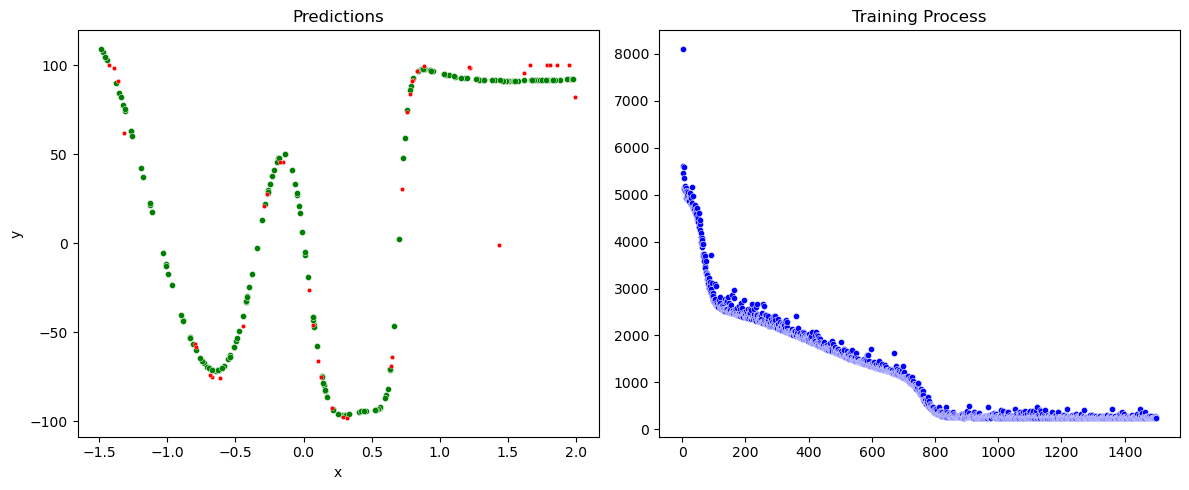

In [74]:
ml = NN([1, 10, 10, 1], initalization='xavier', activations='sigmoid')
y_norm_ml, parameters_ml = standardize_data(Multimodal_Sparse_Train_y)
ml.train(Multimodal_Sparse_Train_X, y_norm_ml, Multimodal_Sparse_Test_X, Multimodal_Sparse_Test_y, denormalize=parameters_ml,
         learning_rate=0.01, epochs=5000, batch_size=0.1,
         beta=0.9,
         target=9, auto_stop=0.02)

ml.plot_combined(Multimodal_Sparse_Test_X, parameters_ml, multimodal_sparse_train)

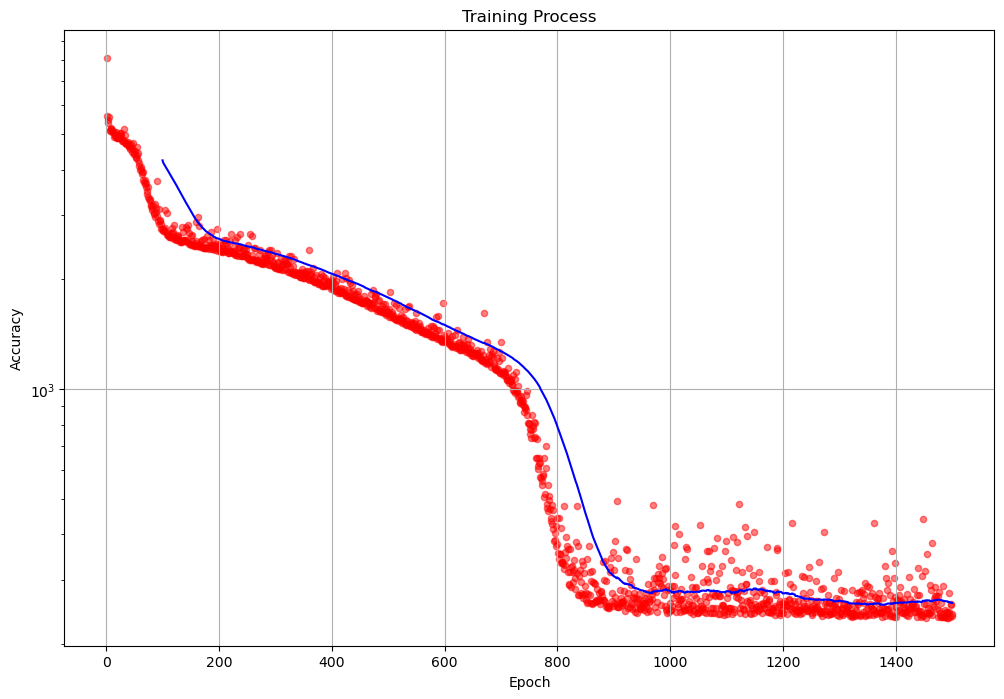

In [76]:
# 5000 * 0.02 = 100. Dlatego sprawdzamy średnią kroczącą dla 100 i tak jak widzimy po niebieskiej funkcji
# na końcu występuje średni wzrost MSE
ml.plot_training_process(100, log=True)

Training complete. | MSE Train:    12.76 | Percentage:   100.00%


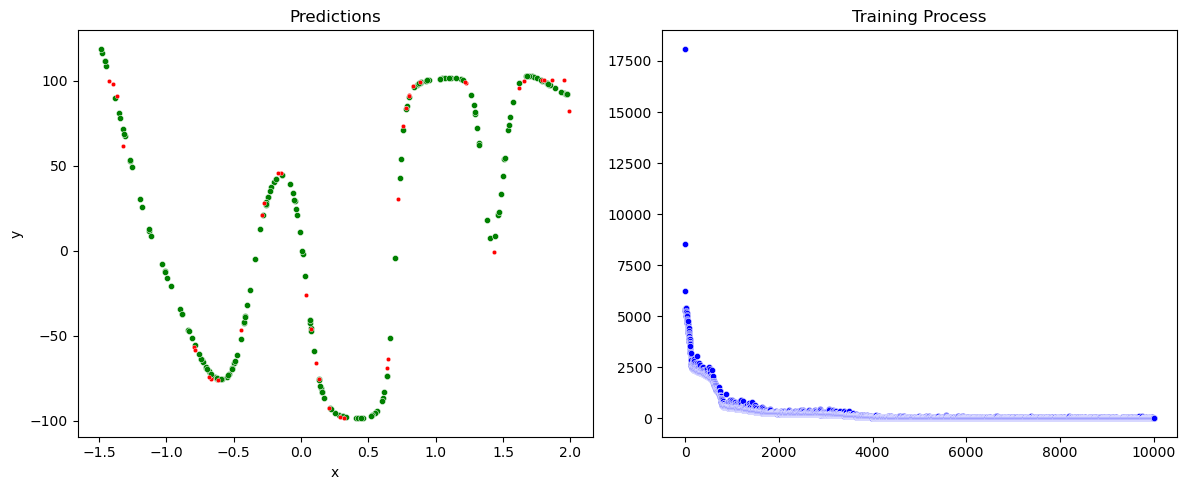

In [77]:
# sigmoid

ml = NN([1, 10, 10, 1], initalization='xavier', activations='sigmoid')
y_norm_ml, parameters_ml = standardize_data(Multimodal_Sparse_Train_y)
ml.train(Multimodal_Sparse_Train_X, y_norm_ml, Multimodal_Sparse_Test_X, Multimodal_Sparse_Test_y, denormalize=parameters_ml,
         learning_rate=0.01, epochs=10000, batch_size=0.1,
         beta=0.9,
         target=9)

ml.plot_combined(Multimodal_Sparse_Test_X, parameters_ml, multimodal_sparse_train)

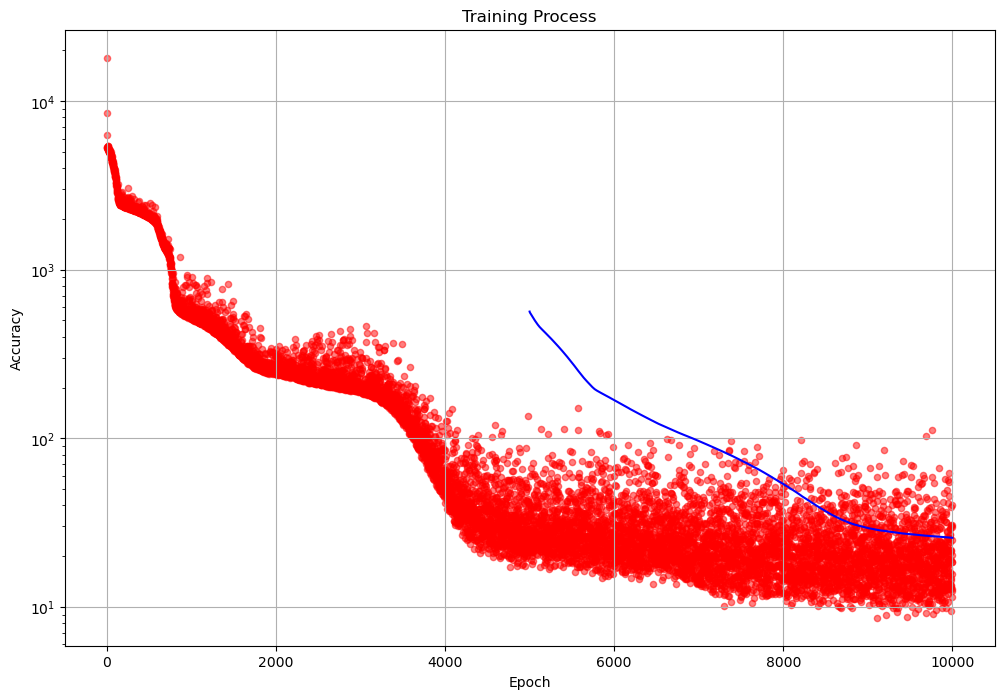

In [78]:
ml.plot_training_process(5000, log=True)
# Jak widzimy na wykresie ze skalą logarytmiczną ostatnie kroki są bardzo rozbieżne. Niebieska linia jest średnią kroczącą.
# Dlatego funkcja stopująca trenowanie z powodu wzrostu MSE musiała być bardziej skomplikowana.

# Rings3

In [7]:
r3 = NN([2, 128, 128, 3], initalization='he', model_type='classification', activations='sigmoid', activation_output='softmax')
r3.train(XY_rings3_balance_train, c_rings3_balance_train, XY_rings3_balance_test, c_rings3_balance_test,
         learning_rate=0.01, epochs=500, batch_size=0.4,
         beta=0.9, target=0.8, auto_stop=0.02)

Expected Overfitting. Needed to stop process. 0.8691 | Percentage:    12.00%
Training complete.


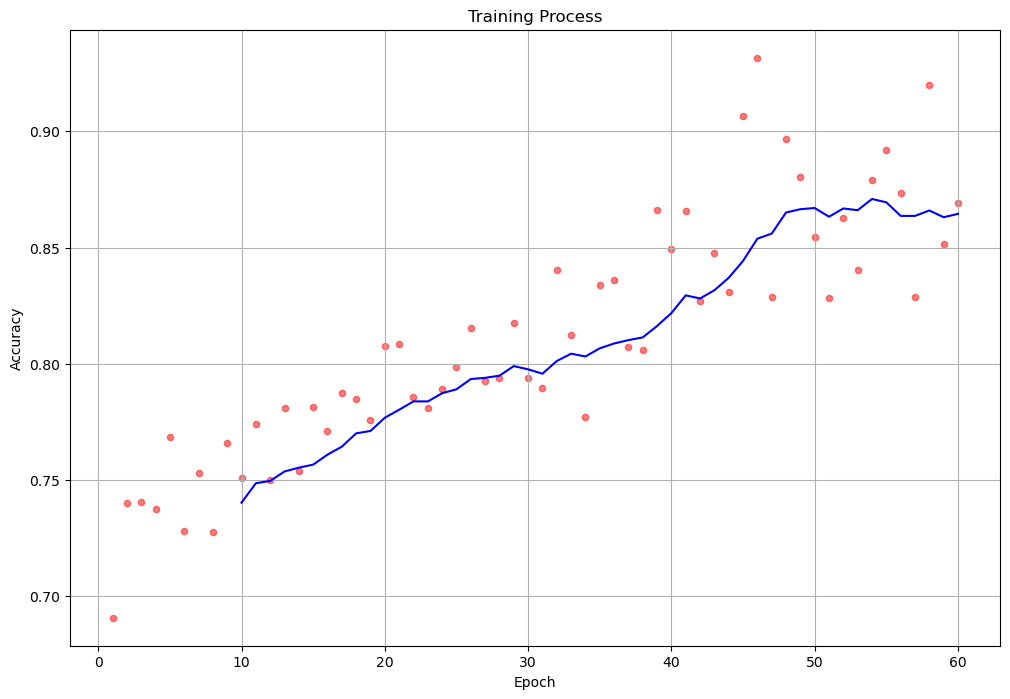

In [8]:
r3.plot_training_process(10)
# Ponownie mechanizm stopu dobrze zadziałał

In [9]:
r3.plot_combined(XY_rings3_balance_train)

# Rings 5

In [26]:
r5 = NN([2, 128, 128, 5], initalization='he', model_type='classification', activations='sigmoid', activation_output='softmax')
r5.train(XY_rings5_sparse_train, c_rings5_sparse_train, XY_rings5_sparse_test, c_rings5_sparse_test,
         learning_rate=0.01, epochs=50000, batch_size=0.4,
         beta=0.9, target=0.82)

Training complete.0.8236 | F-measure Train:   0.9220 | Percentage:     0.22%


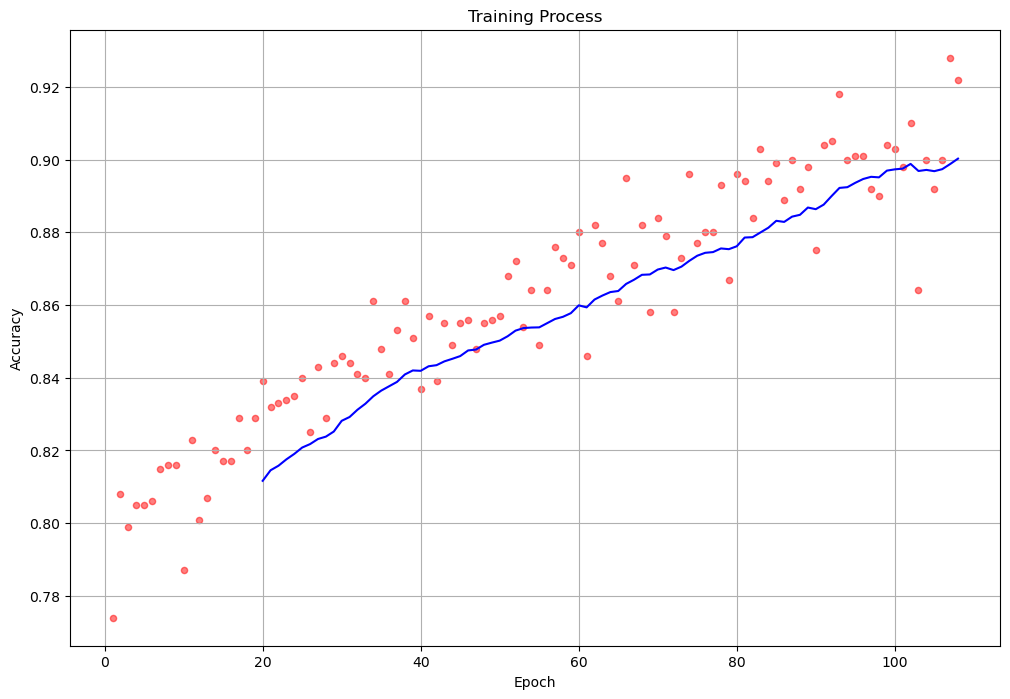

In [27]:
r5.plot_training_process(20)

In [28]:
r5.plot_combined(XY_rings5_sparse_train)

# XOR3

In [31]:
x3 = NN([2, 128, 128, 2], initalization='he', model_type='classification', activations='sigmoid', activation_output='softmax')
x3.train(XY_xor3_balance_train, c_xor3_balance_train, XY_xor3_balance_test, c_xor3_balance_test,
         learning_rate=0.01, epochs=50000, batch_size=0.4,
         beta=0.9, target=0.82)

Training complete.0.8237 | F-measure Train:   0.9733 | Percentage:     0.50%


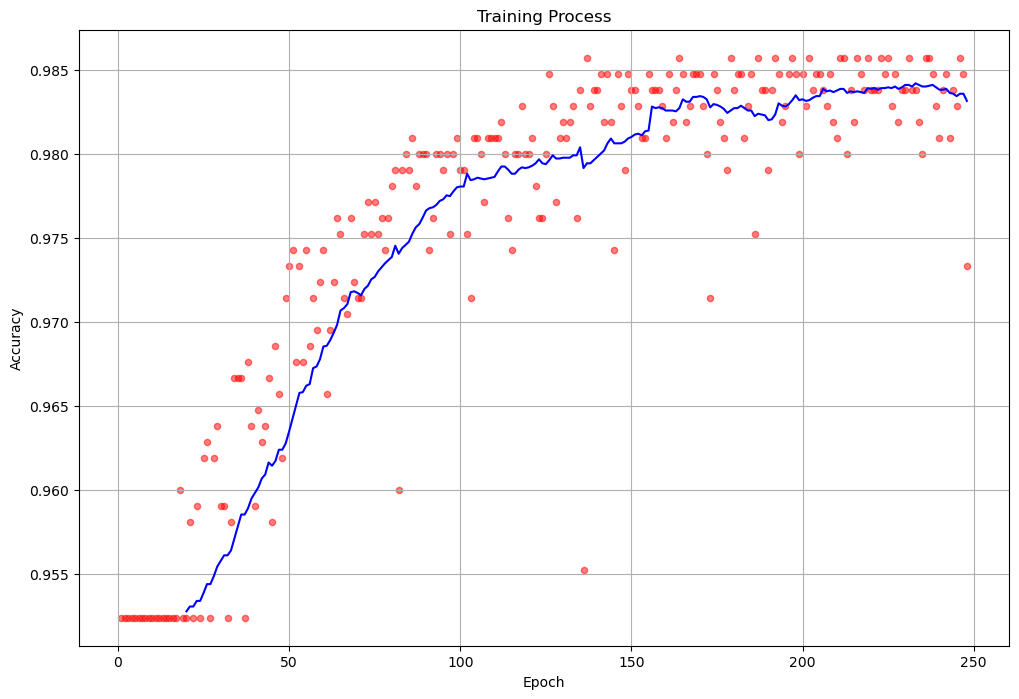

In [32]:
x3.plot_training_process(20)

In [33]:
x3.plot_combined(XY_xor3_balance_train)

# | Najważniejsze obserwacje | Moje spostrzeżenia

#### Mechanizm auto stopu przeciw overfittingowi jest przydatny, zwłaszcza kiedy mamy sporą ilość epoch lub dobieramy porządane parametry. Kiedy szybko trening się zatrzymuje wiemy możemy łatwo wywnioskować niepoprawność parametrów. Co do normalizacji komentarz został przedstawiony na początku notebooke'a.